### Summarize CNN News with classic TextRank with gensim, Seq2Seq with tensorflow and pre-trained **Bart** with transformers 

#### Setup import

In [ ]:
!pip install -r requirements.txt

In [24]:
import datasets
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import contractions
import gensim
import rouge
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing
import transformers

#### Load data

In [12]:
dataset = datasets.load_dataset("cnn_dailymail", "3.0.0")
lst_dics = [dic for dic in dataset["train"]]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [15]:
# keep the first N articles if you want to keep it lite 
dtf = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y"})[["text","y"]].head(20000)
dtf.head()

,text,y
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."


In [17]:
i = 1
print("--- Full text ---")
print(dtf["text"][i])
print("--- Summary ---")
print(dtf["y"][i])

--- Full text ---
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less li

In [18]:
dtf_train = dtf.iloc[i+1:]
dtf_test = dtf.iloc[:i+1]

#### TextRank

* TextRank is very easy to use because it’s unsupervised. First, the whole text is split into sentences, then the algorithm builds a graph where sentences are the nodes and overlapped words are the links. Finally, PageRank identifies the most important nodes of this network of sentences.

In [25]:
def textrank(corpus, ratio=0.2):
    if type(corpus) is str:
        corpus = [corpus]
    lst_summaries = [
        gensim.summarization.summarize(txt, ratio=ratio)
        for txt in corpus
    ]
    return lst_summaries

In [ ]:
predicted = textrank(corpus=dtf["text"], ratio=0.2)
predicted[i]

In [27]:
'''
Find the matching substrings in 2 strings.
:parameter
    :param a: string - raw text
    :param b: string - raw text
:return
    2 lists used in to display matches
'''
def utils_split_sentences(a, b):
    ## find clean matches
    match = difflib.SequenceMatcher(isjunk=None, a=a, b=b, autojunk=True)
    lst_match = [block for block in match.get_matching_blocks() if block.size > 20]
    
    ## difflib didn't find any match
    if len(lst_match) == 0:
        lst_a, lst_b = nltk.sent_tokenize(a), nltk.sent_tokenize(b)
    
    ## work with matches
    else:
        first_m, last_m = lst_match[0], lst_match[-1]

        ### a
        string = a[0 : first_m.a]
        lst_a = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = a[m.a : m.a+m.size]
            lst_a.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = a[m.a+m.size : next_m.a]
                lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = a[last_m.a+last_m.size :]
        lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]

        ### b
        string = b[0 : first_m.b]
        lst_b = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = b[m.b : m.b+m.size]
            lst_b.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = b[m.b+m.size : next_m.b]
                lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = b[last_m.b+last_m.size :]
        lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
    
    return lst_a, lst_b


'''
Highlights the matched strings in text.
:parameter
    :param a: string - raw text
    :param b: string - raw text
    :param both: bool - search a in b and, if True, viceversa
    :param sentences: bool - if False matches single words
:return
    text html, it can be visualized on notebook with display(HTML(text))
'''
def display_string_matching(a, b, both=True, sentences=True, titles=[]):
    if sentences is True:
        lst_a, lst_b = utils_split_sentences(a, b)
    else:
        lst_a, lst_b = a.split(), b.split()       
    
    ## highlight a
    first_text = []
    for i in lst_a:
        if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_b]:
            first_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
        else:
            first_text.append(i)
    first_text = ' '.join(first_text)
    
    ## highlight b
    second_text = []
    if both is True:
        for i in lst_b:
            if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_a]:
                second_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
            else:
                second_text.append(i)
    else:
        second_text.append(b) 
    second_text = ' '.join(second_text)
    
    ## concatenate
    if len(titles) > 0:
        first_text = "<strong>"+titles[0]+"</strong><br>"+first_text
    if len(titles) > 1:
        second_text = "<strong>"+titles[1]+"</strong><br>"+second_text
    else:
        second_text = "---"*65+"<br><br>"+second_text
    final_text = first_text +'<br><br>'+ second_text
    return final_text

In [ ]:
match = display_string_matching(dtf_test["y"][i], predicted[i], both=True, sentences=False, titles=["Real Summary", "Predicted Summary"])
from IPython.core.display import display, HTML
display(HTML(match))

#### Seq2Seq model

* texts are padded into sequences with the same length to get a feature matrix
* word embeddings: feature learning techniques where words from the vocabulary are mapped to vectors of real numbers which are calculated from the probability distribution for each word appearing before or after another
* encoder-decoder structure: encoder processes the input sequence and returns its own internal states that serve as the context for the decoder, which predicts the next word of the target sequence, given the previous ones
* model for training and model for predictions: the model used in training isn’t directly used to predict. In fact, we shall code 2 neural networks (both with an Encoder-Decoder structure), one used for training and the other (called “Inference Model”) to generate predictions by leveraging some of the layers from the trained model

In [44]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexandru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alexandru/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexandru/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/alexandru/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexandru/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#### Text cleaning

In [32]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords = lst_stopwords + ["cnn","say","said","new"]

In [35]:
def utils_preprocess_text(txt, punkt=True, lower=True, slang=True, lst_stopwords=None, stemm=False, lemm=True):
    # separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    # remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    # strip
    txt = " ".join([word.strip() for word in txt.split()])
    # lowercase
    txt = txt.lower() if lower is True else txt
    # slang
    txt = contractions.fix(txt) if slang is True else txt   
    # tokenize (convert from string to list)
    lst_txt = txt.split()
    # stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
    # lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]
    # remove Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in 
                   lst_stopwords]
    # back to string
    txt = " ".join(lst_txt)
    return txt

dtf_train["text_clean"] = dtf_train["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
dtf_train["y_clean"] = dtf_train["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))

/tmp/ipykernel_30594/2128376351.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["text_clean"] = dtf_train["text"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True))
/tmp/ipykernel_30594/2128376351.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["y_clean"] = dtf_train["y"].apply(lambda x: utils_preprocess_text(x, punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, stemm=False, lemm=True)

In [39]:
X_len = 400
y_len = 40

In [45]:
lst_tokens = nltk.tokenize.word_tokenize(dtf_train["text_clean"].str.cat(sep=" "))
ngrams = [1]

/tmp/ipykernel_30594/3801469695.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_freq = dtf_freq.append(dtf_n)
/tmp/ipykernel_30594/3801469695.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))


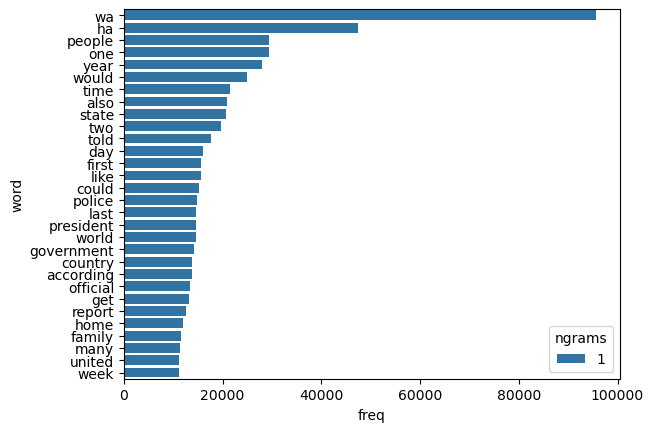

In [48]:
dtf_freq = pd.DataFrame()
for n in ngrams:
   dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
   dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
   dtf_n["ngrams"] = n
   dtf_freq = dtf_freq.append(dtf_n)
   dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
   dtf_freq_X= dtf_freq.sort_values(["ngrams", "freq"], ascending=[True,False])
    
# plot
sns.barplot(x="freq", y="word", hue="ngrams", dodge=False,
    data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(30))
plt.show()

In [49]:
thres = 5
X_top_words = len(dtf_freq_X[dtf_freq_X["freq"]>thres])
y_top_words = len(dtf_freq_y[dtf_freq_y["freq"]>thres])

NameError: name 'dtf_freq_y' is not defined